#Chapter 8 - Regression Model
We'll be buidling an expected TD regression model for RBs.

% allows use to use command line. pip is pythons package manager and allows us to install external packages. --upgrade ensures we have to the most recent package

In [1]:
#suppress output with capture
%%capture 
%pip install nfl_data_py --upgrade

In [2]:
import pandas as pd
import nfl_data_py as nfl
import numpy as np
import warnings; warnings.simplefilter('ignore')

##Get Data

In [3]:
seasons = range(2008,2022)
df = nfl.import_pbp_data(seasons)

df.head()

2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
0,1.0,2008_01_ARI_SF,2008090711,SF,ARI,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37.0,2008_01_ARI_SF,2008090711,SF,ARI,REG,1,SF,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,63.0,2008_01_ARI_SF,2008090711,SF,ARI,REG,1,SF,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84.0,2008_01_ARI_SF,2008090711,SF,ARI,REG,1,SF,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106.0,2008_01_ARI_SF,2008090711,SF,ARI,REG,1,SF,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(676290, 384)

##Manage Columns  

In [5]:
for column in df.columns:
    # looking for rushing relevant columns
    if 'rush' in column:
        print(column)
    # looking for yard line and distance to endzone relevant columns
    elif 'distance' in column:
        print(column)
    elif 'yardline' in column:
        print(column)
    elif 'attempt' in column:
        print(column)

yardline_100
kick_distance
total_home_rush_epa
total_away_rush_epa
total_home_rush_wpa
total_away_rush_wpa
first_down_rush
rush_attempt
pass_attempt
rush_touchdown
extra_point_attempt
two_point_attempt
field_goal_attempt
kickoff_attempt
punt_attempt
lateral_rush
rusher_player_id
rusher_player_name
rushing_yards
lateral_rusher_player_id
lateral_rusher_player_name
lateral_rushing_yards
defensive_two_point_attempt
defensive_extra_point_attempt
rusher
rusher_jersey_number
rush
rusher_id
number_of_pass_rushers


In [6]:
rushing_df = df[['rush_attempt', 'rush_touchdown', 'yardline_100', 'two_point_attempt']]
rushing_df = rushing_df.loc[(rushing_df['rush_attempt'] == 1) & (rushing_df['two_point_attempt'] == 0)]
rushing_df.sort_values(by='yardline_100', ascending=False).head()

,rush_attempt,rush_touchdown,yardline_100,two_point_attempt
151211,1.0,0.0,99.0,0.0
387991,1.0,0.0,99.0,0.0
233760,1.0,0.0,99.0,0.0
423499,1.0,0.0,99.0,0.0
37343,1.0,0.0,99.0,0.0


Grouping by yardline_100. Counting the rush_touchdown values (either 1=yes, 0=no). So "probability_of_touchdown" column shows the count. 2100 TDs from 1 yd line, 1687 rushes from 1 yd line without TD.

In [7]:
rushing_df_probs = rushing_df.groupby('yardline_100')['rush_touchdown'].value_counts()

rushing_df_probs.index

MultiIndex([( 1.0, 1.0),
            ( 1.0, 0.0),
            ( 2.0, 0.0),
            ( 2.0, 1.0),
            ( 3.0, 0.0),
            ( 3.0, 1.0),
            ( 4.0, 0.0),
            ( 4.0, 1.0),
            ( 5.0, 0.0),
            ( 5.0, 1.0),
            ...
            (94.0, 0.0),
            (94.0, 1.0),
            (95.0, 0.0),
            (96.0, 0.0),
            (97.0, 0.0),
            (97.0, 1.0),
            (98.0, 0.0),
            (98.0, 1.0),
            (99.0, 0.0),
            (99.0, 1.0)],
           names=['yardline_100', 'rush_touchdown'], length=196)

Need to convert this series object to a df - make df on fly.
We start with the probability column as the counts we just found (see above). But we also want to remove redundant info - we don't need both probability of TD and no TD. So use normalize to turn this into percentages, and then drop the No TD row. 

We then attempt to index this df we just created with the index from the rushing_df_probs, but we have to reset that since that object was a series and it was a multi-index of two columns. Look above to see the previous index.

In [8]:
#bring that previous line of code back just to edit here...
rushing_df_probs = rushing_df.groupby('yardline_100')['rush_touchdown'].value_counts(normalize=True)

#want to convert this series object to a df
rushing_df_probs = pd.DataFrame({
    'probability_of_touchdown': rushing_df_probs.values
}, index=rushing_df_probs.index).reset_index()

rushing_df_probs.head()

,yardline_100,rush_touchdown,probability_of_touchdown
0,1.0,1.0,0.554529
1,1.0,0.0,0.445471
2,2.0,0.0,0.586875
3,2.0,1.0,0.413125
4,3.0,0.0,0.664029


Drop the No TD probability

In [9]:
rushing_df_probs = rushing_df_probs.loc[rushing_df_probs['rush_touchdown'] == 1]
rushing_df_probs = rushing_df_probs.drop('rush_touchdown', axis = 1)
rushing_df_probs.head(15)

,yardline_100,probability_of_touchdown
0,1.0,0.554529
3,2.0,0.413125
5,3.0,0.335971
7,4.0,0.279770
9,5.0,0.205882
11,6.0,0.156932
13,7.0,0.147353
15,8.0,0.133047
17,9.0,0.084093
19,10.0,0.091549


##Probability Distribution plotting

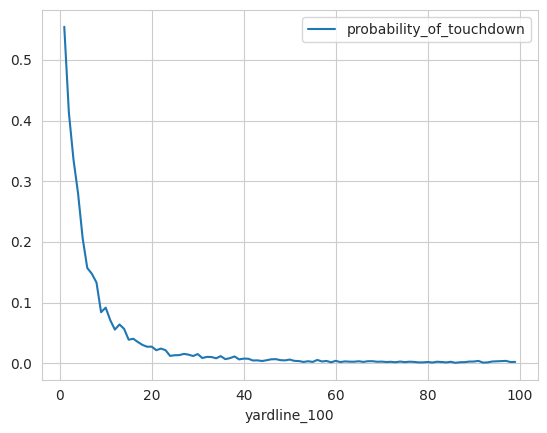

In [10]:
import seaborn as sns; sns.set_style('whitegrid')

rushing_df_probs.plot(x='yardline_100', y='probability_of_touchdown');

##2022 Play-By-Play Data



In [11]:
pbp_2022 = nfl.import_pbp_data([2022])

for column in pbp_2022.columns:
    # looking for rushing relevant columns
    if 'rush' in column:
        print(column)
    # looking for yard line and distance to endzone relevant columns
    elif 'distance' in column:
        print(column)
    elif 'yardline' in column:
        print(column)
    elif 'attempt' in column:
        print(column)

2022 done.
Downcasting floats.
yardline_100
kick_distance
total_home_rush_epa
total_away_rush_epa
total_home_rush_wpa
total_away_rush_wpa
first_down_rush
rush_attempt
pass_attempt
rush_touchdown
extra_point_attempt
two_point_attempt
field_goal_attempt
kickoff_attempt
punt_attempt
lateral_rush
rusher_player_id
rusher_player_name
rushing_yards
lateral_rusher_player_id
lateral_rusher_player_name
lateral_rushing_yards
defensive_two_point_attempt
defensive_extra_point_attempt
rusher
rusher_jersey_number
rush
rusher_id
number_of_pass_rushers


In [12]:
pbp_2022 = pbp_2022[['rusher_player_name', 'rusher_player_id', 'posteam', 'rush_touchdown', 'yardline_100']].dropna()
pbp_2022.head()

,rusher_player_name,rusher_player_id,posteam,rush_touchdown,yardline_100
2,Mi.Carter,00-0036924,NYJ,0.0,78.0
4,Mi.Carter,00-0036924,NYJ,0.0,59.0
9,L.Jackson,00-0034796,BAL,0.0,64.0
10,K.Drake,00-0033118,BAL,0.0,60.0
12,K.Drake,00-0033118,BAL,0.0,52.0


##Merge probability df with regression data

In [41]:
#creating expected td df
exp_df = pbp_2022.merge(rushing_df_probs, how='left', on='yardline_100') 
#this uses a left join - all left (pbp_2022) join with matching data from right (rushing_df_probs)
exp_df.head()

,rusher_player_name,rusher_player_id,posteam,rush_touchdown,yardline_100,probability_of_touchdown
0,Mi.Carter,00-0036924,NYJ,0.0,78.0,0.001346
1,Mi.Carter,00-0036924,NYJ,0.0,59.0,0.001527
2,L.Jackson,00-0034796,BAL,0.0,64.0,0.002457
3,K.Drake,00-0033118,BAL,0.0,60.0,0.003909
4,K.Drake,00-0033118,BAL,0.0,52.0,0.003516


Modifying exp_df. Group by various columns, don't set these columns as the index. Aggregating - want to sum the probability of touchdowns and rush TDs for each player - 1 row/player. Then rename those two columns. 

Have to add axis=1 when renaming/dropping columns so that pd knows we are renaming columns not the index.

In [42]:
import numpy as np

exp_df = exp_df.groupby(['rusher_player_name', 'rusher_player_id', 'posteam'], as_index = False).agg({
    'probability_of_touchdown': np.sum,
    'rush_touchdown': np.sum
}).rename({
    'probability_of_touchdown': 'Expected Touchdowns',
    'rush_touchdown': 'Actual Touchdowns'
}, axis=1)

exp_df = exp_df.sort_values(by='Expected Touchdowns', ascending=False)
exp_df.head()

,rusher_player_name,rusher_player_id,posteam,Expected Touchdowns,Actual Touchdowns
214,Ja.Williams,00-0033948,DET,17.408436,17.0
180,J.Hurts,00-0036389,PHI,15.284469,18.0
132,E.Elliott,00-0033045,DAL,11.319867,12.0
193,J.Mixon,00-0033897,CIN,11.221726,8.0
85,D.Cook,00-0033893,MIN,9.635063,8.0


Model thinks Hurts overperformed rushing TD expectations.

In [43]:
exp_df = exp_df.rename({
    "rusher_player_name": "Player", 
    "posteam": "Team",
    "rusher_player_id":"ID"
}, axis=1)

exp_df.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns
214,Ja.Williams,00-0033948,DET,17.408436,17.0
180,J.Hurts,00-0036389,PHI,15.284469,18.0
132,E.Elliott,00-0033045,DAL,11.319867,12.0
193,J.Mixon,00-0033897,CIN,11.221726,8.0
85,D.Cook,00-0033893,MIN,9.635063,8.0


##Import roster data

to filter out non-RBs

In [44]:
roster = nfl.import_rosters([2022])
roster.head()

,season,team,position,depth_chart_position,jersey_number,status,player_name,first_name,last_name,birth_date,...,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number
0,2022,ARI,DB,FS,31.0,R/Injured,Chris Banjo,Ayorunmi,Banjo,1990-02-26,...,REG,R01,Chris,BAN373418,39941,32004241-4e37-3418-7494-6de47748ece8,2013,2013,None,NaN
1,2022,ARI,DB,FS,28.0,Active,Charles Washington,Charles,Washington,1993-03-10,...,REG,A01,Charles,WAS082938,43680,32005741-5308-2938-c497-7cfd2d22cbf6,2016,2016,None,NaN
2,2022,ARI,DB,CB,33.0,Active,Antonio Hamilton,Antonio,Hamilton,1993-01-24,...,REG,A01,Antonio,HAM184824,43986,32004841-4d18-4824-5017-25555a65166e,2016,2016,None,NaN
3,2022,ARI,DB,SS,3.0,R/Injured,Budda Baker,Budda,Baker,1996-01-10,...,REG,R01,Budda,BAK070449,44848,32004241-4b07-0449-419d-4d7a3da71f8e,2017,2017,ARI,36.0
4,2022,ARI,DB,CB,27.0,Prac Sq.; Inj,Nate Hairston,Nathan,Hairston,1994-06-30,...,REG,P02,Nate,HAI741950,44971,32004841-4974-1950-1414-941e1bb47e67,2017,2017,IND,158.0


In [45]:
#using the code below, we know we can match roster and exp_df on player_id and ID
#for player_name = Jalen Hurts, show the player_id
roster.loc[(roster['player_name']=='Jalen Hurts', 'player_id')]

2114    00-0036389
Name: player_id, dtype: object

In [46]:
#filter roster down to just two columns, rename them
roster = roster[['player_id','position']].rename({
    'player_id':'ID'
}, axis=1)

roster.head()

,ID,position
0,00-0029747,DB
1,00-0032560,DB
2,00-0032933,DB
3,00-0033890,DB
4,00-0033568,DB


In [47]:
#left join - add roster onto exp_df
exp_df = exp_df.merge(roster, on='ID', how='left')
exp_df.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,position
0,Ja.Williams,00-0033948,DET,17.408436,17.0,RB
1,J.Hurts,00-0036389,PHI,15.284469,18.0,QB
2,E.Elliott,00-0033045,DAL,11.319867,12.0,RB
3,J.Mixon,00-0033897,CIN,11.221726,8.0,RB
4,D.Cook,00-0033893,MIN,9.635063,8.0,RB


In [48]:
#filter to only RBs, drop position column
exp_df = exp_df.loc[exp_df['position']=='RB'].drop('position', axis=1)
exp_df.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns
0,Ja.Williams,00-0033948,DET,17.408436,17.0
2,E.Elliott,00-0033045,DAL,11.319867,12.0
3,J.Mixon,00-0033897,CIN,11.221726,8.0
4,D.Cook,00-0033893,MIN,9.635063,8.0
5,J.Jacobs,00-0035700,LV,9.371359,12.0


In [49]:
exp_df['Actual Touchdowns Rank'] = exp_df['Actual Touchdowns'].rank(ascending=False)
exp_df

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Actual Touchdowns Rank
0,Ja.Williams,00-0033948,DET,17.408436,17.0,1.0
2,E.Elliott,00-0033045,DAL,11.319867,12.0,6.5
3,J.Mixon,00-0033897,CIN,11.221726,8.0,12.5
4,D.Cook,00-0033893,MIN,9.635063,8.0,12.5
5,J.Jacobs,00-0035700,LV,9.371359,12.0,6.5
...,...,...,...,...,...,...
322,J.Cabinda,00-0034171,DET,0.010405,0.0,126.5
346,R.Bonnafon,00-0034578,WAS,0.004655,0.0,126.5
354,T.Jones,00-0035860,NO,0.004149,0.0,126.5
368,T.Badie,00-0037085,DEN,0.002461,0.0,126.5


In [56]:
exp_df['Regression Candidate'] = exp_df['Expected Touchdowns'] - exp_df['Actual Touchdowns']
exp_df

exp_df.sort_values(by='Regression Candidate', ascending=True)
#ascending true shows actual reg candidates, false is underperformed

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Actual Touchdowns Rank,Regression Candidate
10,A.Ekeler,00-0033699,LAC,8.474638,15.0,2.0,-6.525362
8,D.Henry,00-0032764,TEN,8.902119,13.0,3.5,-4.097881
7,M.Sanders,00-0035243,PHI,9.252068,13.0,3.5,-3.747932
12,N.Chubb,00-0034791,CLE,8.285513,12.0,6.5,-3.714487
31,T.Pollard,00-0035261,DAL,5.301556,9.0,10.0,-3.698444
...,...,...,...,...,...,...,...
3,J.Mixon,00-0033897,CIN,11.221726,8.0,12.5,3.221726
6,T.Etienne,00-0036973,JAX,9.325063,6.0,19.0,3.325063
30,B.Robinson,00-0037746,WAS,5.389459,2.0,56.5,3.389459
20,L.Fournette,00-0033856,TB,6.444318,3.0,42.0,3.444318


##Visualizing Results

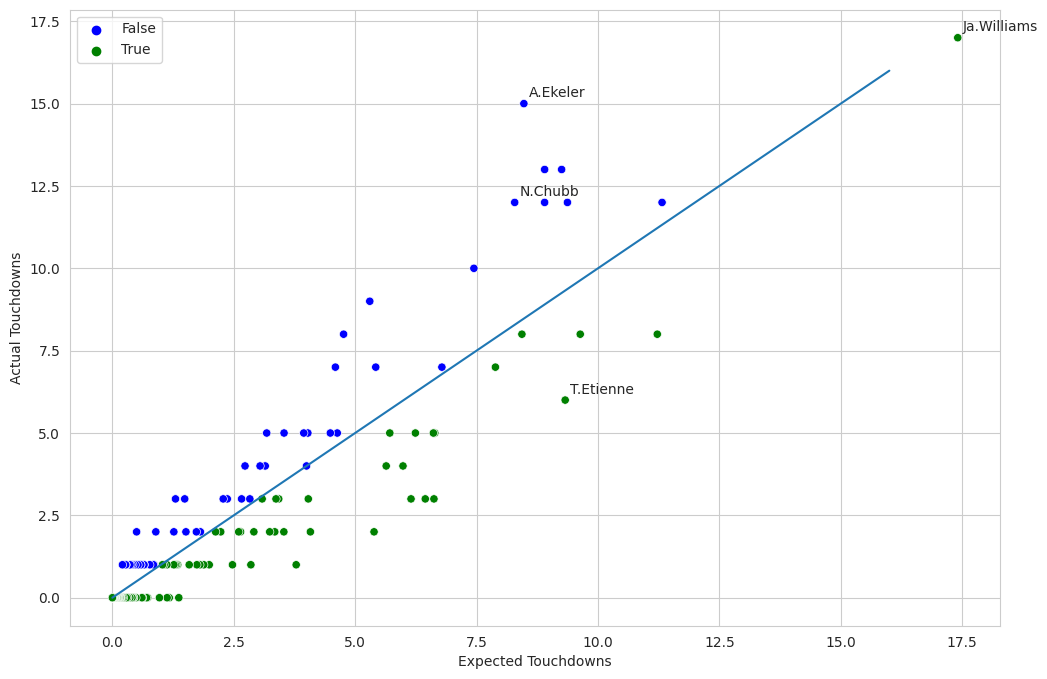

In [72]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots(figsize = (12,8))
exp_df['Positive Regression Candidate'] = exp_df['Regression Candidate'] > 0 

sns.scatterplot(
    data=exp_df,
    x='Expected Touchdowns',
    y='Actual Touchdowns',
    hue='Positive Regression Candidate',
    palette=['b','g']
)

max_act_touchdowns = int(exp_df['Actual Touchdowns'].max())
max_exp_touchdowns = int(exp_df['Expected Touchdowns'].max())
max_tds_act_vs_exp = max(max_act_touchdowns, max_exp_touchdowns)

sns.lineplot(x=range(max_tds_act_vs_exp), y=range(max_tds_act_vs_exp));

# initialize a list of notable players we'd like to annotate the visualization with.
notable_players = ['T.Etienne', 'Ja.Williams', 'A.Ekeler', 'N.Chubb']
for _, row in exp_df.iterrows():
    if row['Player'] in notable_players: 
        """
        Check out the docs on Axes.text
        https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.text.html
        Notice we are using the ax object we instantiated above.
        """
        ax.text(
            x = row['Expected Touchdowns']+0.1, # add a bit of spacing from the point in the x-direction
            y = row['Actual Touchdowns'] + 0.2, # same but in the y-direction
            s = row['Player'] # annotate with the player's name
        )